## This notebook presents some experiments built upon PyTorch3D "Fit Mesh"tutorial

Check the original notebook at: https://pytorch3d.org/tutorials/deform_source_mesh_to_target_mesh

In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.loss import (
    chamfer_distance, 
    mesh_edge_loss, 
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
import numpy as np

from tqdm import notebook
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
device = torch.device("cpu")

In [2]:
from extensions_utils import cylinder, surface_of_revolution

In [3]:
DATA_FOLDER = os.path.join('data', 'meshes', 'fairly-smooth')
def locate_mesh(name:str):
    return os.path.join(DATA_FOLDER, name)

def plot_pointcloud(mesh, title=""):
    # Sample points uniformly from the surface of the mesh.
    points = sample_points_from_meshes(mesh, 5000)
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [21]:
def deform_mesh(src_mesh, trg_mesh, steps=2000, wc=1.0, we=1.0, wn=0.01, wl=0.1, plot_period=500):
    # We will learn to deform the source mesh by offsetting its vertices
    # The shape of the deform parameters is equal to the total number of vertices in src_mesh
    deform_verts = torch.full(src_mesh.verts_packed().shape, 0.0, device=device, requires_grad=True)
    # The optimizer
    optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

    # Number of optimization steps
    Niter = steps
    # Weight for the chamfer loss
    w_chamfer = wc 
    # Weight for mesh edge loss
    w_edge = we 
    # Weight for mesh normal consistency
    w_normal = wn
    # Weight for mesh laplacian smoothing
    w_laplacian = wl 
    # Plot period for the losses
    plot_period = plot_period
    loop = notebook.tqdm(range(Niter))

    chamfer_losses = []
    laplacian_losses = []
    edge_losses = []
    normal_losses = []

    %matplotlib inline

    for i in loop:
        # Initialize optimizer
        optimizer.zero_grad()

        # Deform the mesh
        new_src_mesh = src_mesh.offset_verts(deform_verts)

        # We sample 5k points from the surface of each mesh 
        sample_trg = sample_points_from_meshes(trg_mesh, 5000)
        sample_src = sample_points_from_meshes(new_src_mesh, 5000)

        # We compare the two sets of pointclouds by computing (a) the chamfer loss
        loss_chamfer, _ = chamfer_distance(sample_trg, sample_src)

        # and (b) the edge length of the predicted mesh
        loss_edge = mesh_edge_loss(new_src_mesh)

        # mesh normal consistency
        loss_normal = mesh_normal_consistency(new_src_mesh)

        # mesh laplacian smoothing
        loss_laplacian = mesh_laplacian_smoothing(new_src_mesh, method="uniform")

        # Weighted sum of the losses
        loss = loss_chamfer * w_chamfer + loss_edge * w_edge + loss_normal * w_normal + loss_laplacian * w_laplacian

        # Print the losses
        loop.set_description('total_loss = %.6f' % loss)

        # Save the losses for plotting
        chamfer_losses.append(loss_chamfer)
        edge_losses.append(loss_edge)
        normal_losses.append(loss_normal)
        laplacian_losses.append(loss_laplacian)

        # Plot mesh
        if i % plot_period == 0:
            plot_pointcloud(new_src_mesh, title="iter: %d" % i)

        # Optimization step
        loss.backward()
        optimizer.step()
    
    print('Weights:\n Chamfer: {} | Edge: {} | Normal: {} | Laplacian: {}'.format(wc, we, wn, wl))    
    # Visualize Loss
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    ax.plot(chamfer_losses, label="chamfer loss")
    ax.plot(edge_losses, label="edge loss")
    ax.plot(normal_losses, label="normal loss")
    ax.plot(laplacian_losses, label="laplacian loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")
    plt.show()

    
    return new_src_mesh

def save_mesh(mesh, path):
    # Fetch the verts and faces of the final predicted mesh
    final_verts, final_faces = mesh.get_mesh_verts_faces(0)
    
    # Store the predicted mesh using save_obj
    final_obj = locate_mesh(path)
    save_obj(final_obj, final_verts, final_faces)

## Initialization of some meshes for experiments

In [8]:
from math import cos, sin, exp, log, sqrt, atan, acos

In [9]:
def line(u):
    return 2*u

def rev_exp(u):
    return 1 + exp(u)

def rev_log(u):
    return 1 + log(0.1 + u)

def rev_parabola(u):
    return u**2

def rev_hiperbole(u):
    return sqrt((u+1)**2 - 1)

def pseudo_sphere(u):
    return 4*atan(exp(u))

def rev_circle(u):
    return sqrt(1-u**2)

curves = {
    'cone': line,
    'paraboloid': rev_parabola,
    'rev_exp': rev_exp,
    'rev_log': rev_log,
    'hiperboloid': rev_hiperbole,
    'pseudo_sphere': pseudo_sphere,
    'rev_circle': rev_circle
}

## Defining pairs of meshes to be deformed one into another

In [24]:
pairs = (
    (('cylinder', cylinder(1, 2, 100, 50)), ('cone', surface_of_revolution(line))),
    (('cone', surface_of_revolution(line, 100, 50)), ('cylinder', cylinder(1, 2, 50, 10))), 
    (('exp', surface_of_revolution(rev_exp, 100, 50)), ('log', surface_of_revolution(rev_log))),
    (('log', surface_of_revolution(rev_log, 100, 50)), ('exp', surface_of_revolution(rev_exp))), 
    (('paraboloid', surface_of_revolution(rev_parabola, 100, 50)), ('hiperboloid', surface_of_revolution(rev_hiperbole))), 
    (('pseudo_sphere', surface_of_revolution(pseudo_sphere, 100, 50)), ('sphere', ico_sphere(3))),
    (('semi_sphere', surface_of_revolution(rev_circle, 100, 50)), ('sphere', ico_sphere(3))),
)


Deforming cylinder into cone


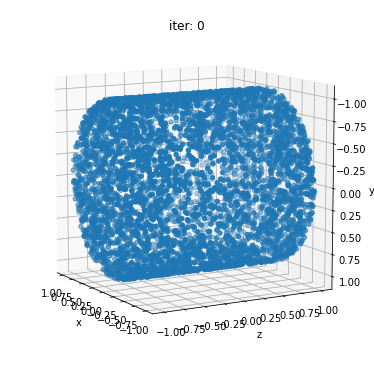

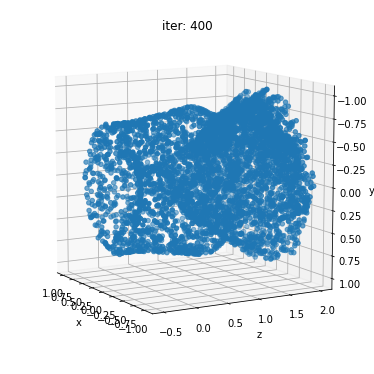

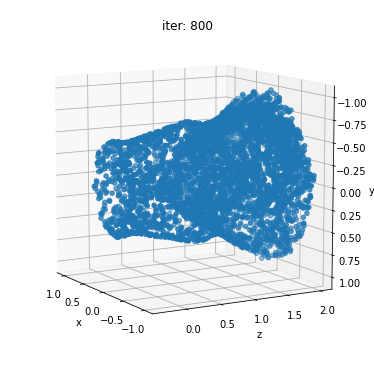

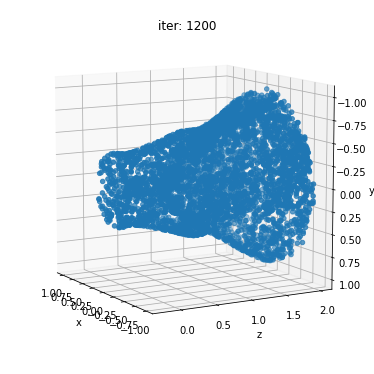


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


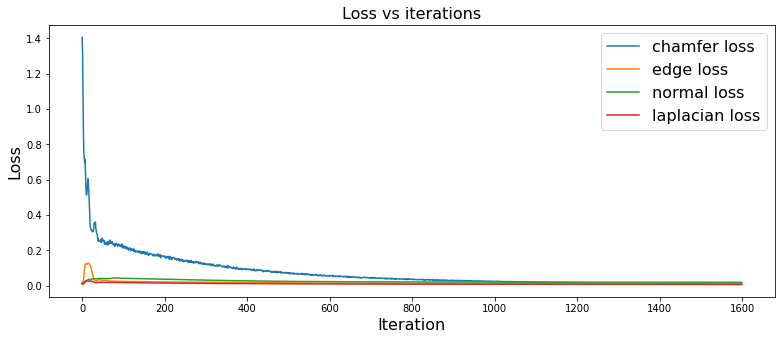


Deforming cone into cylinder


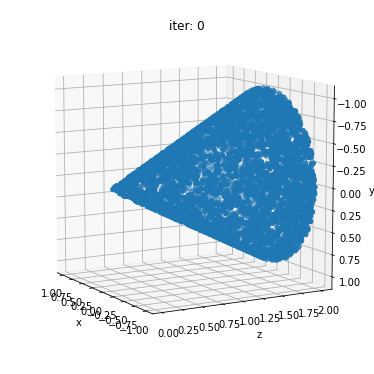

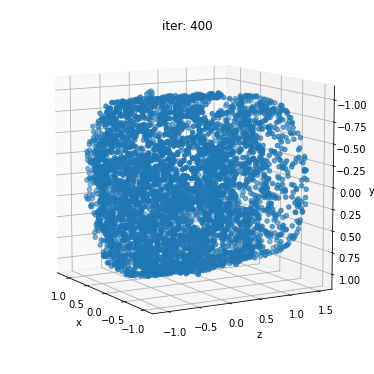

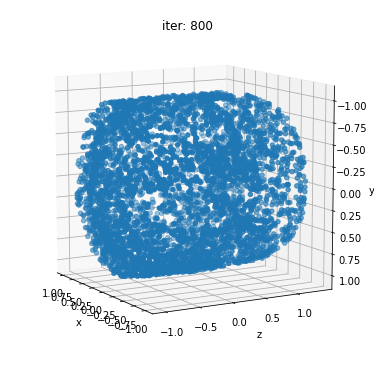

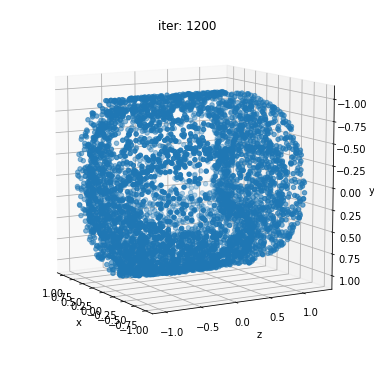


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


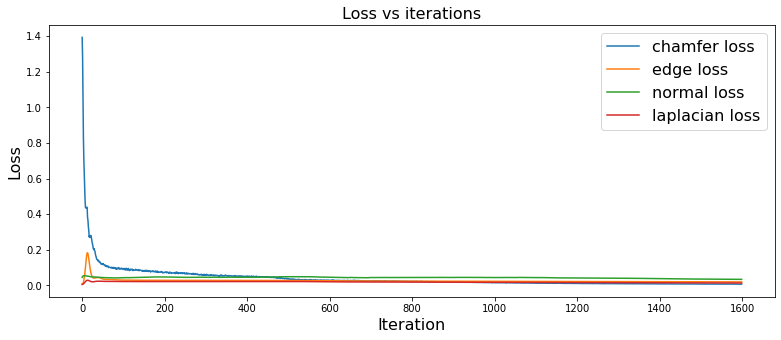


Deforming exp into log


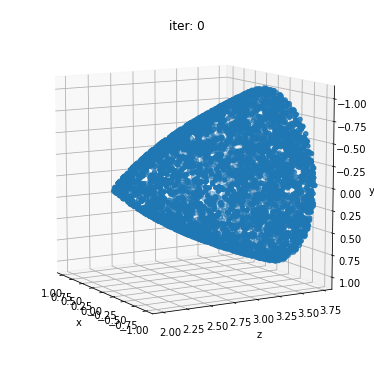

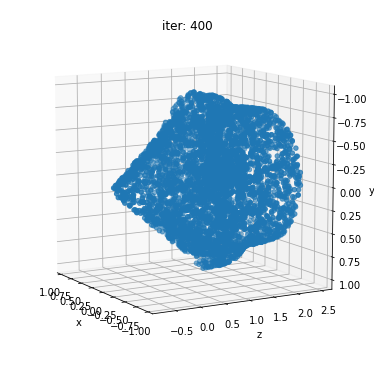

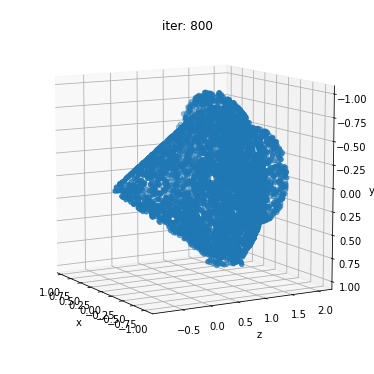

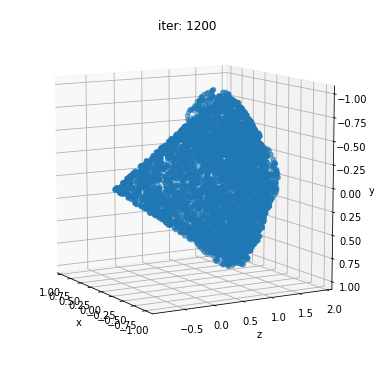


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


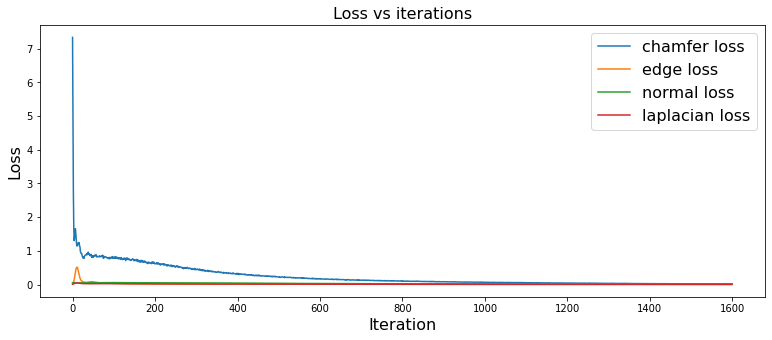


Deforming log into exp


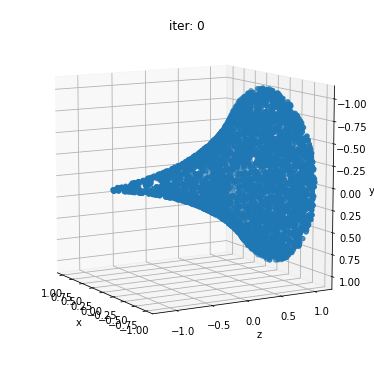

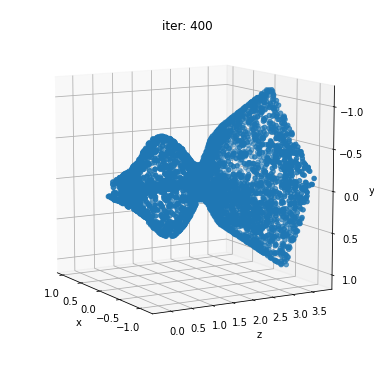

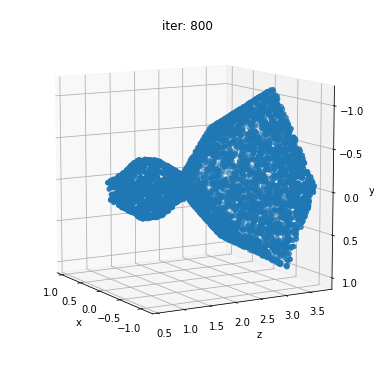

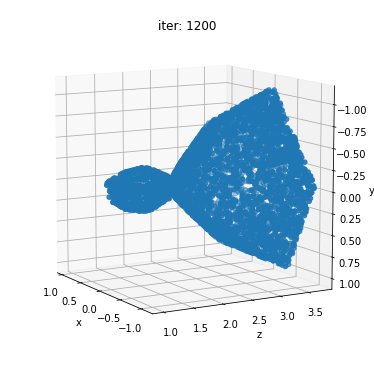


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


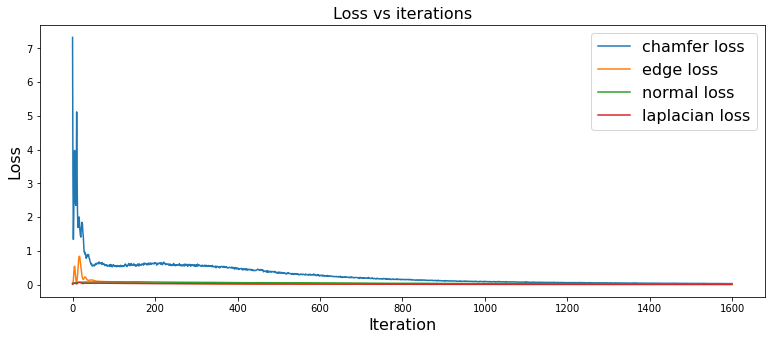


Deforming paraboloid into hiperboloid


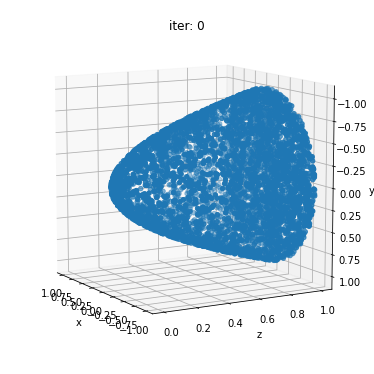

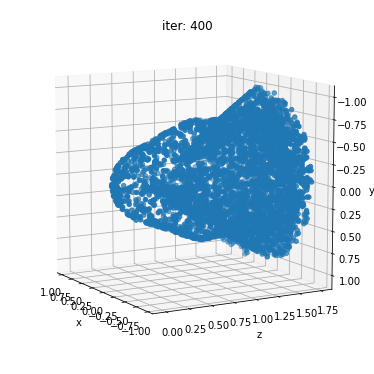

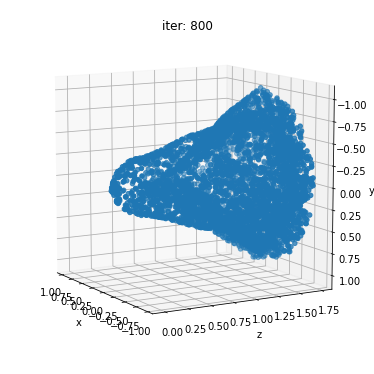

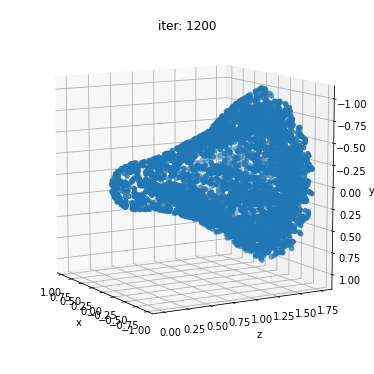


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


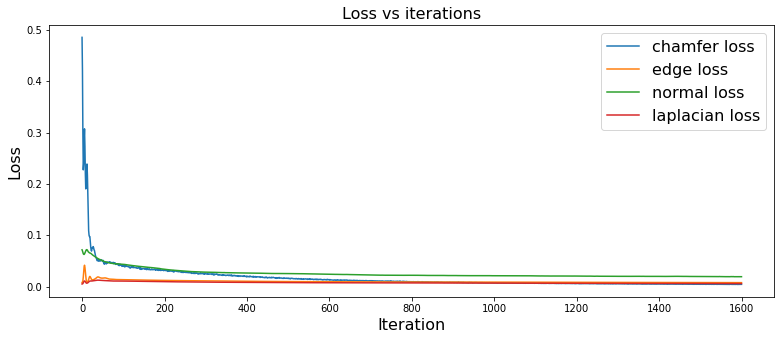


Deforming pseudo_sphere into sphere


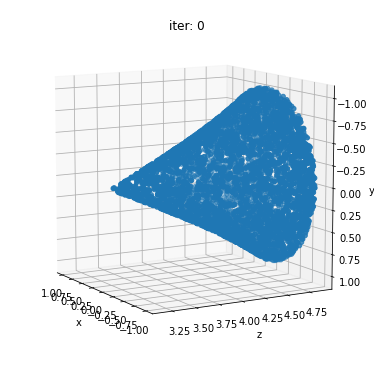

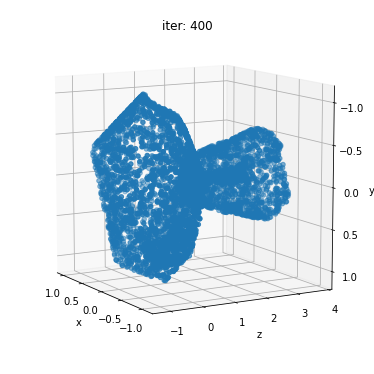

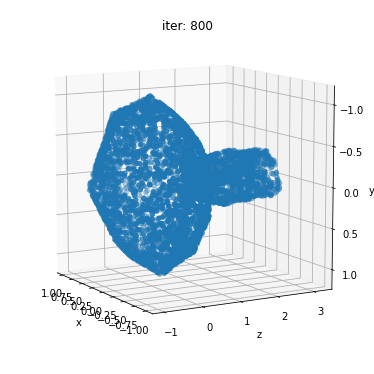

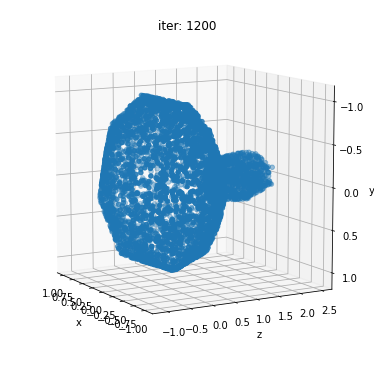


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


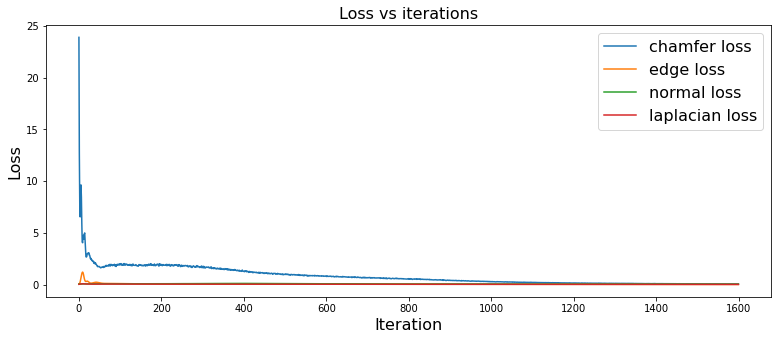


Deforming semi_sphere into sphere


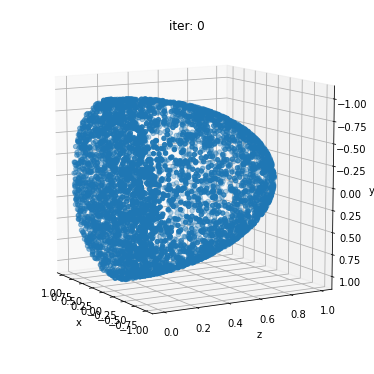

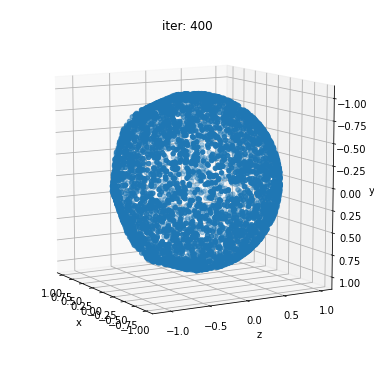

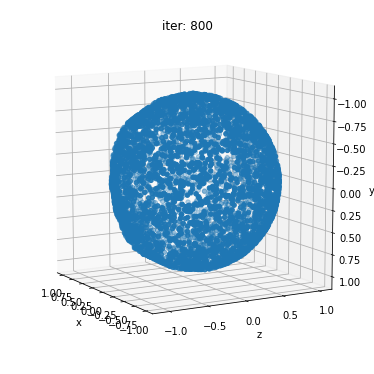

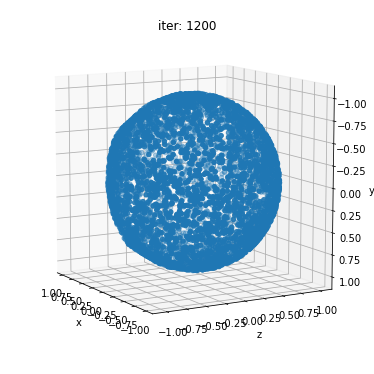


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


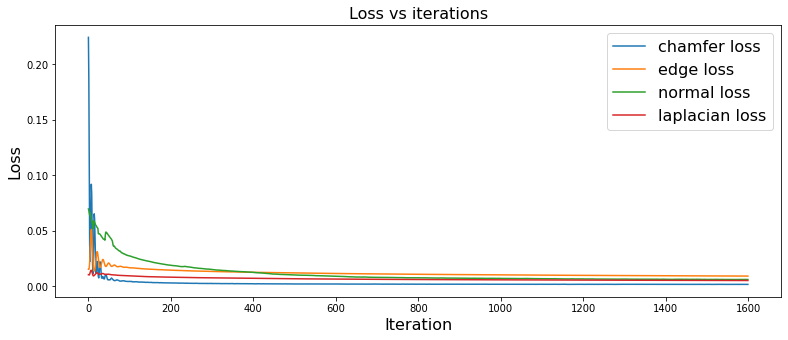

In [23]:
for source, target in pairs:
    print('\nDeforming {} into {}'.format(source[0], target[0]))
    optimized_mesh = deform_mesh(source[1], target[1], steps=1600, plot_period=400)
    save_mesh(optimized_mesh, 'opt-{}-{}.obj'.format(source[0], target[0]))


Deforming cylinder into cone


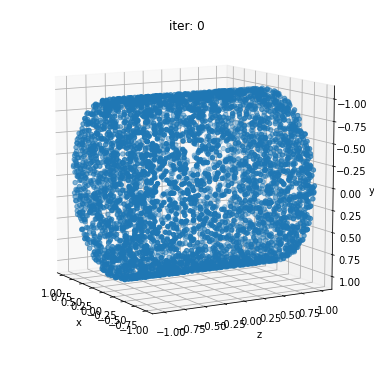

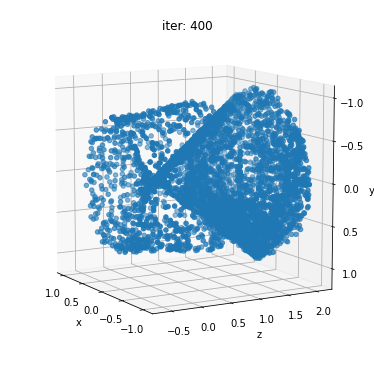

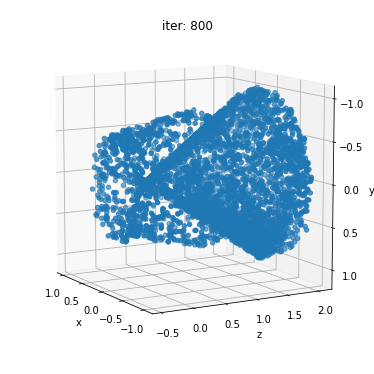

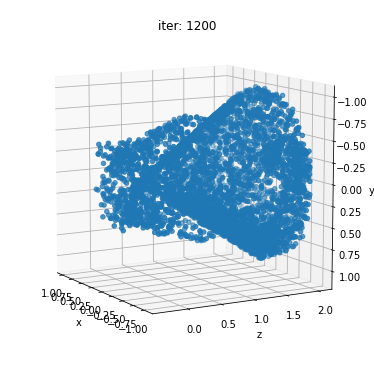


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


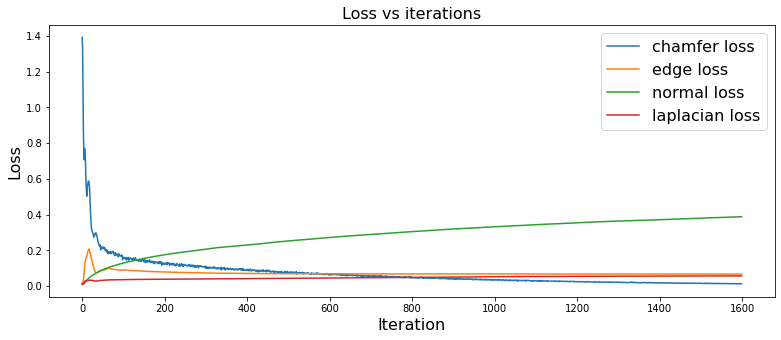


Deforming cone into cylinder


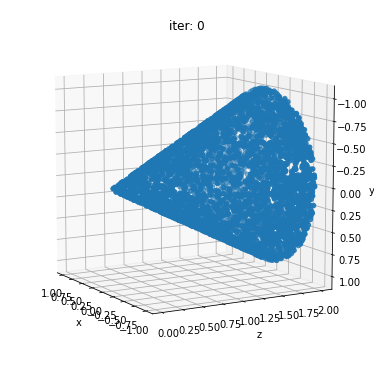

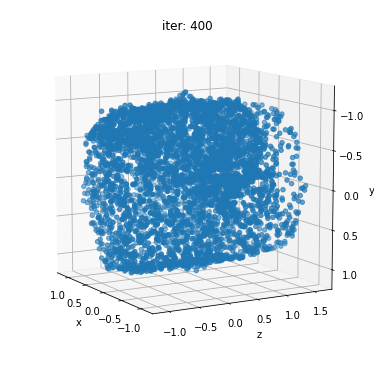

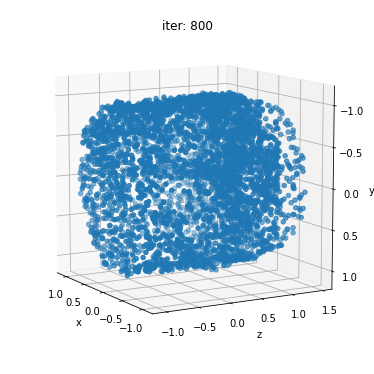

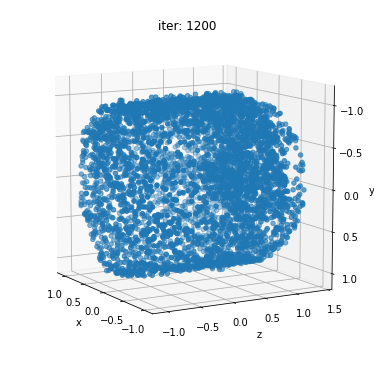


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


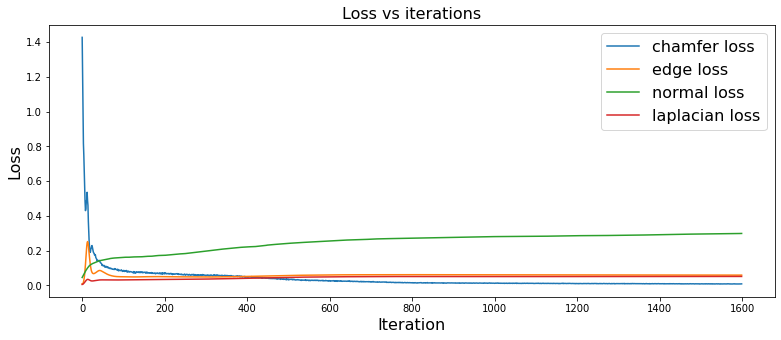


Deforming exp into log


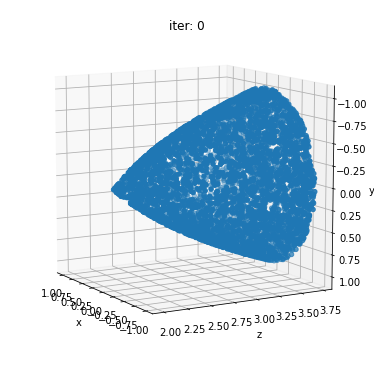

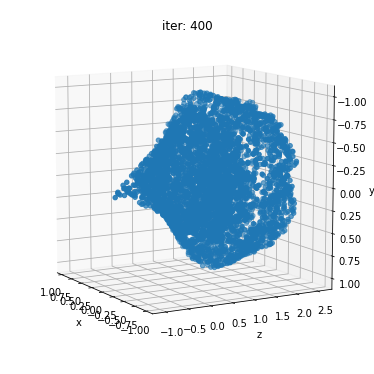

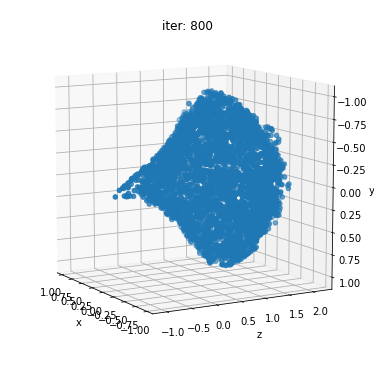

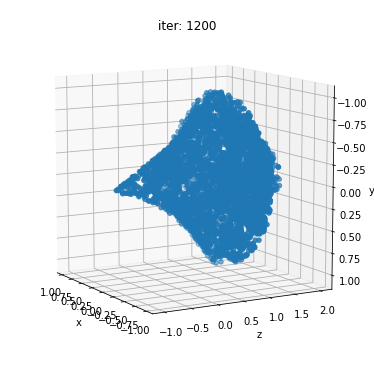


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


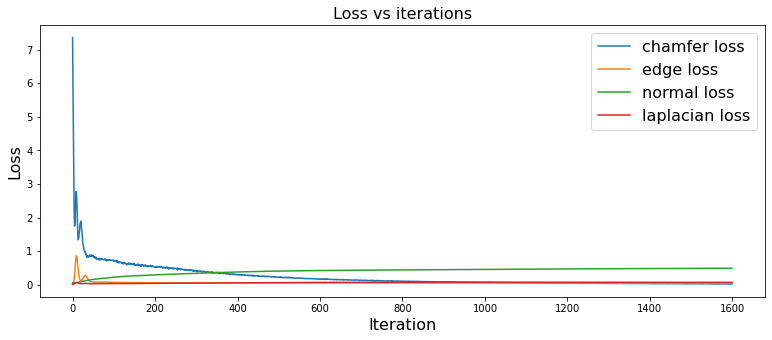


Deforming log into exp


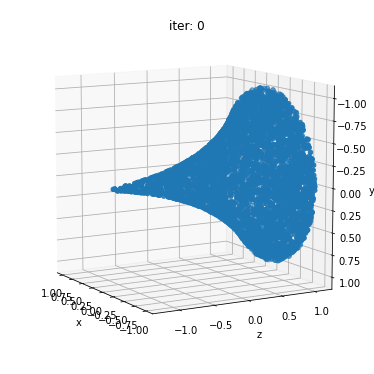

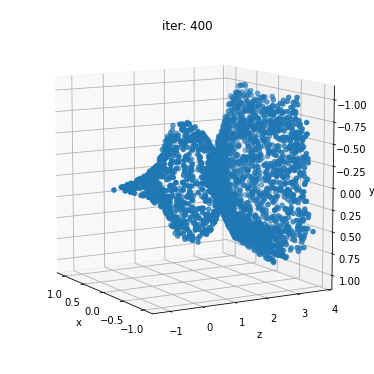

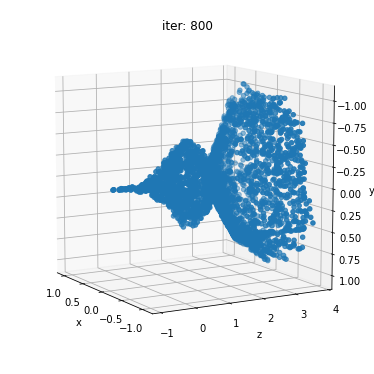

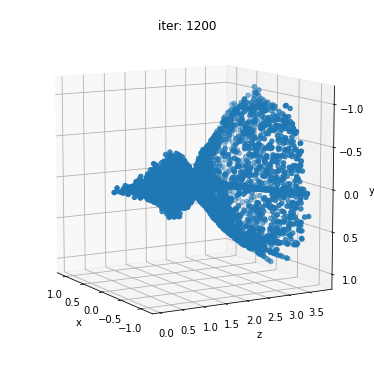


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


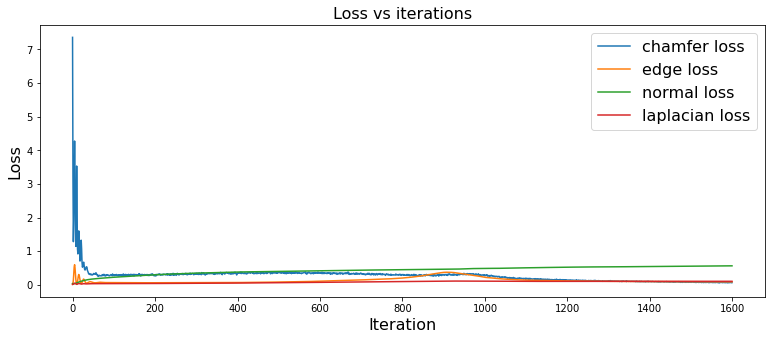


Deforming paraboloid into hiperboloid


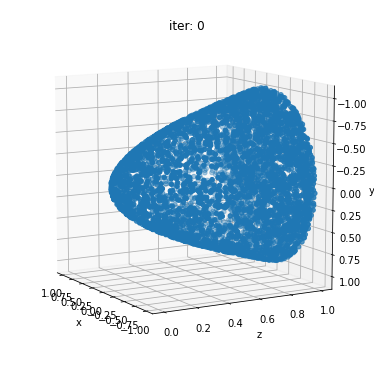

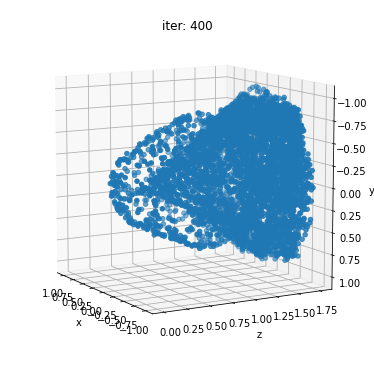

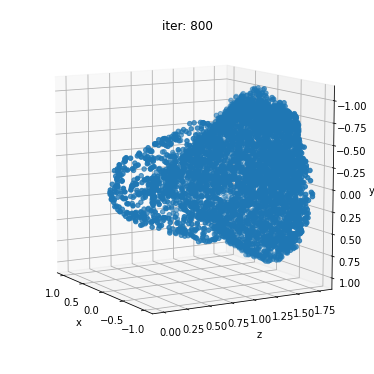

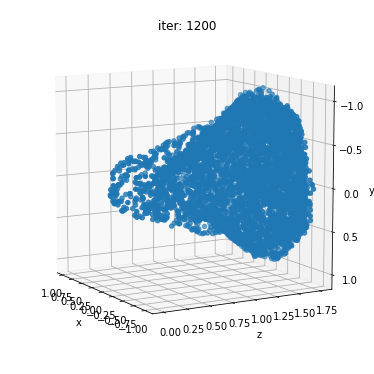


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


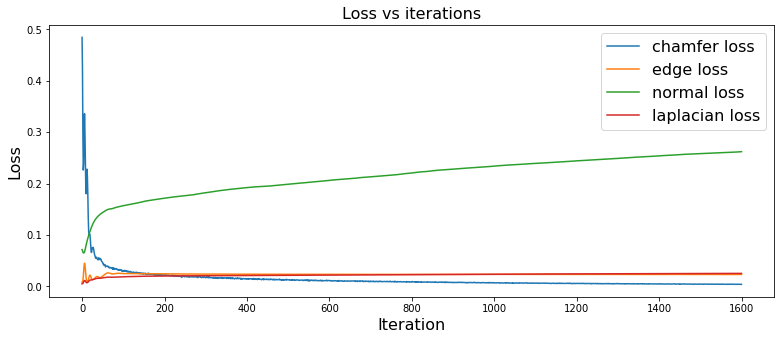


Deforming pseudo_sphere into sphere


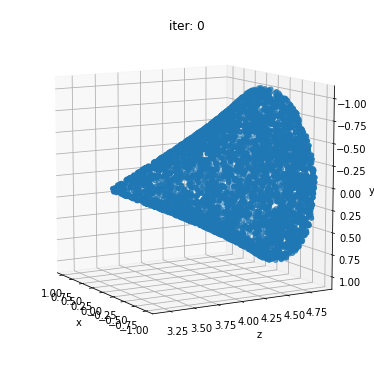

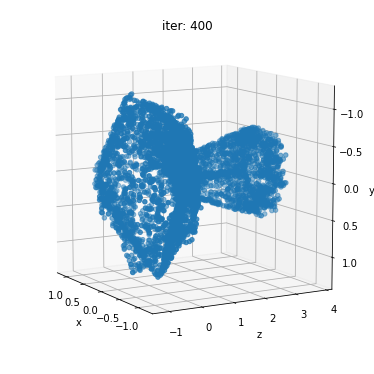

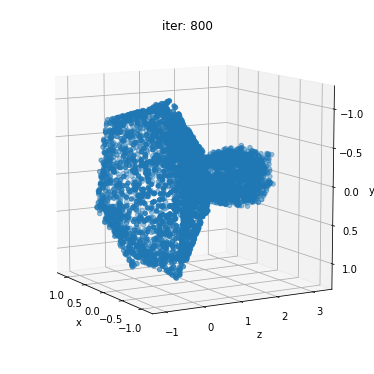

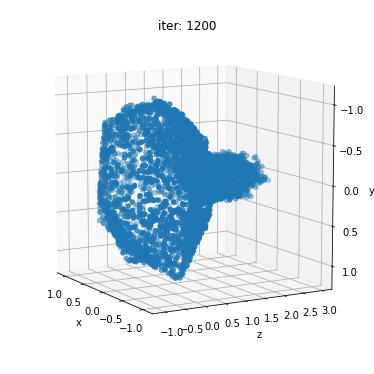


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


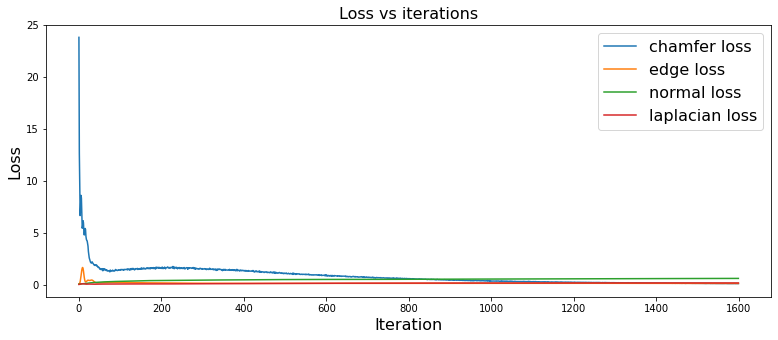


Deforming semi_sphere into sphere


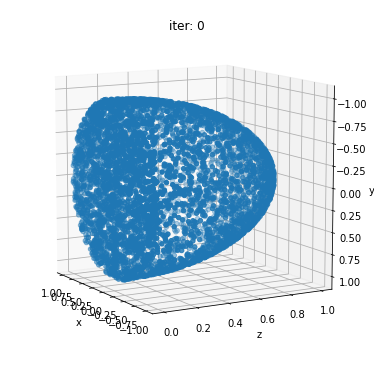

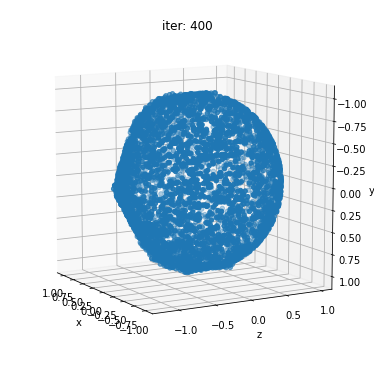

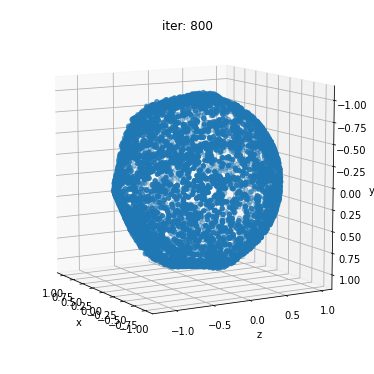

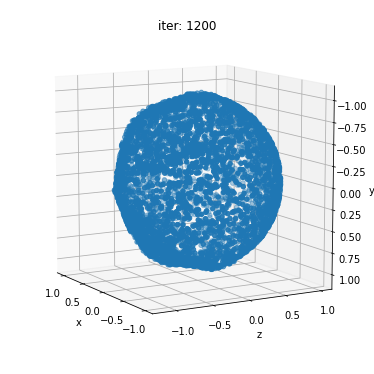


Weights:
 Chamfer: 1.0 | Edge: 0 | Normal: 0 | Laplacian: 0


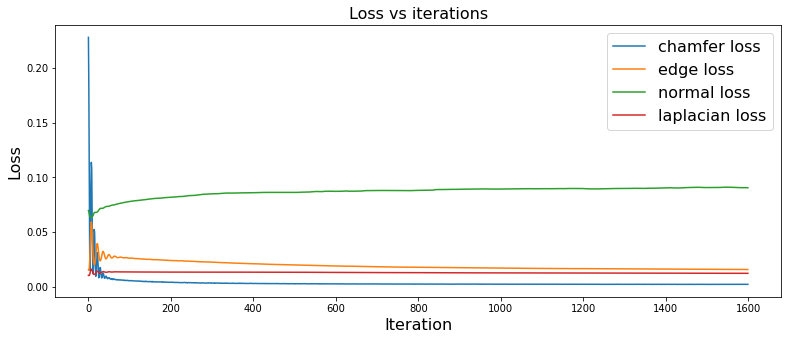

In [20]:
#before smoothness
for source, target in pairs:
    print('\nDeforming {} into {}'.format(source[0], target[0]))
    optimized_mesh = deform_mesh(source[1], target[1], steps=1600, plot_period=400)
    save_mesh(optimized_mesh, 'opt-{}-{}.obj'.format(source[0], target[0]))


Deforming cylinder into cone


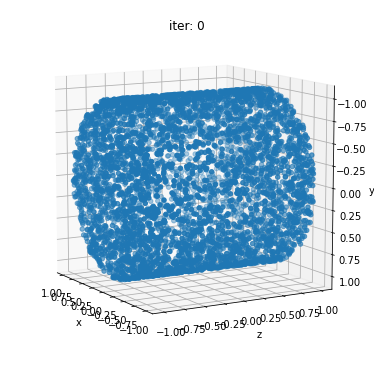

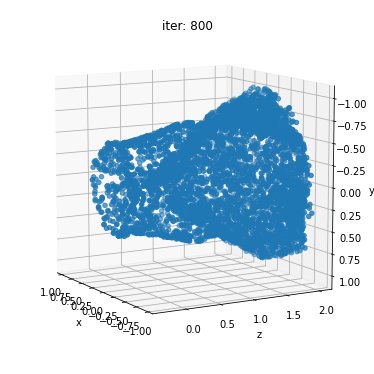

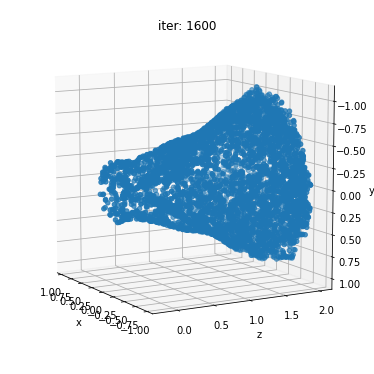


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


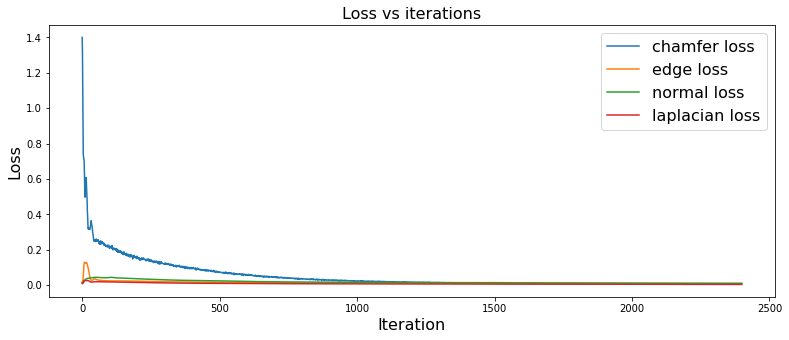


Deforming cone into cylinder


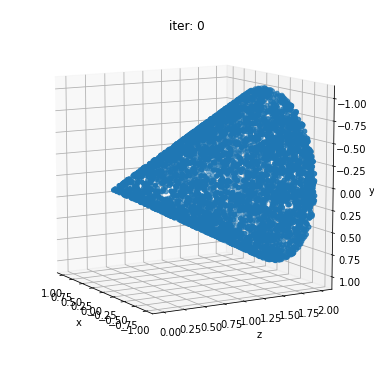

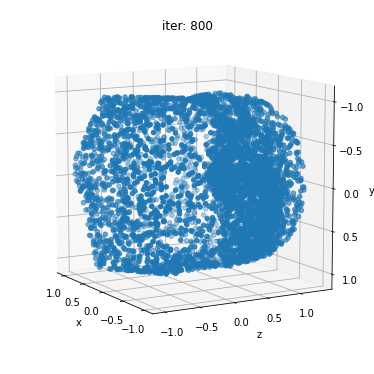

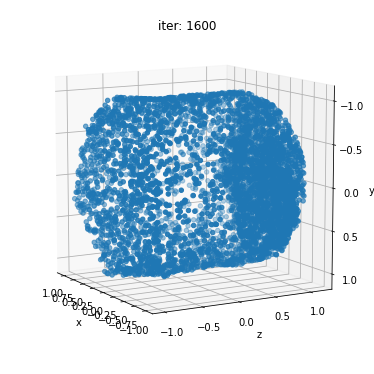


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


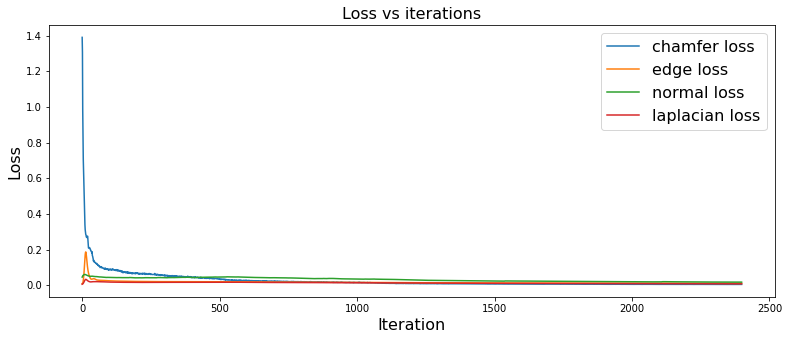


Deforming exp into log


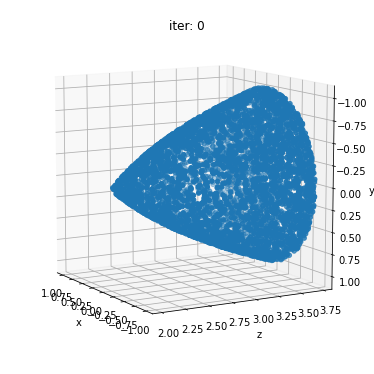

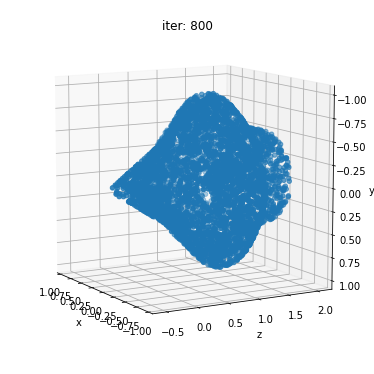

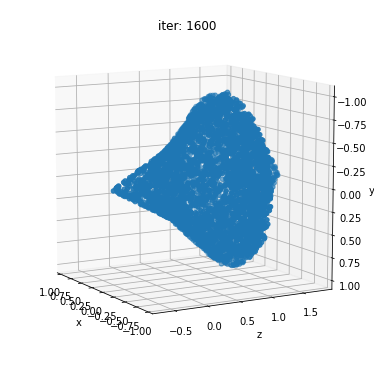


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


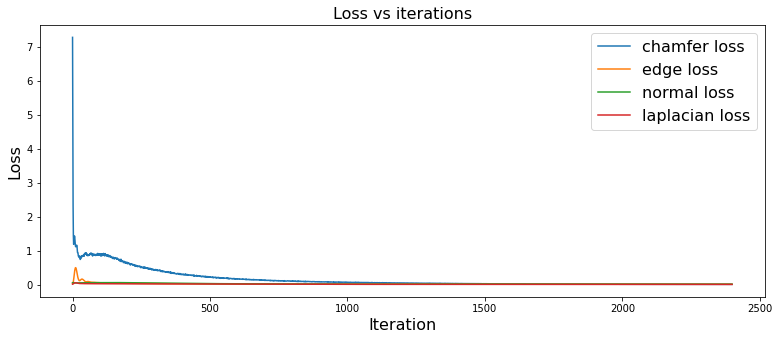


Deforming log into exp


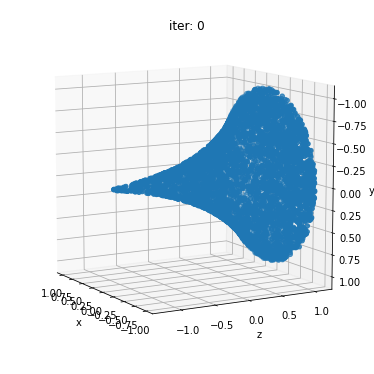

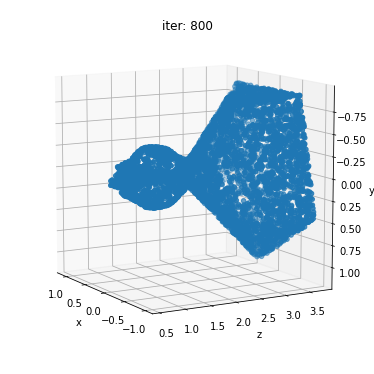

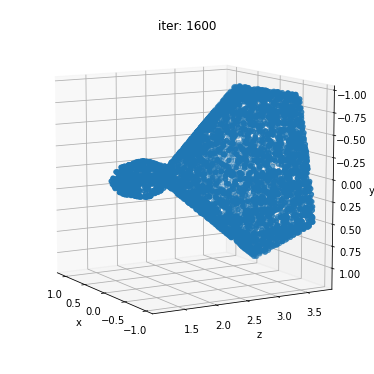


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


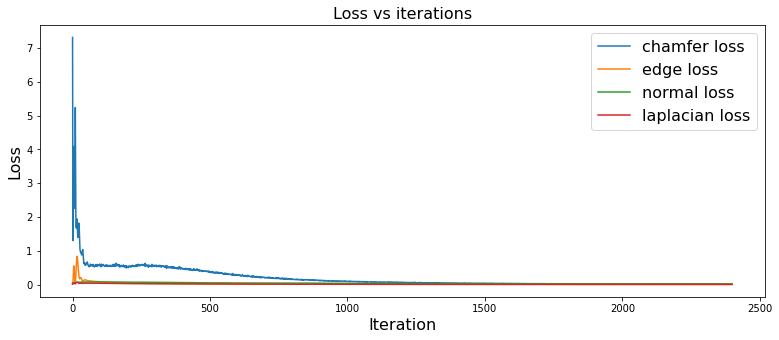


Deforming paraboloid into hiperboloid


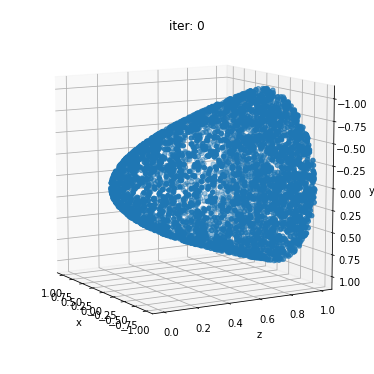

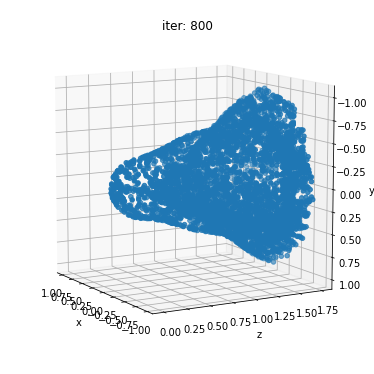

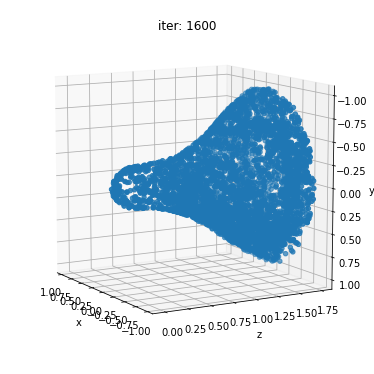


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


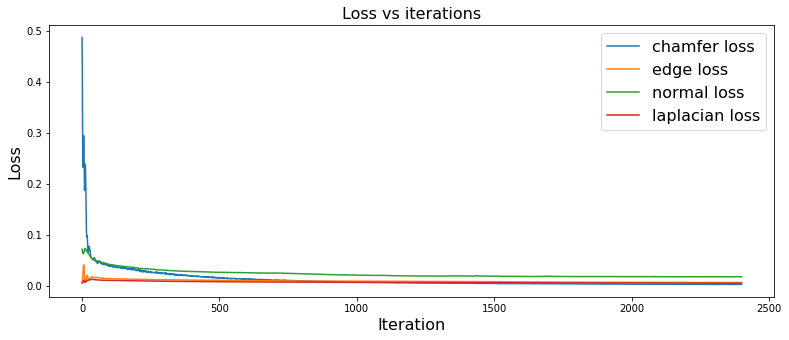


Deforming pseudo_sphere into sphere


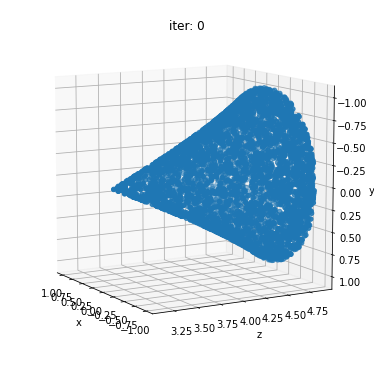

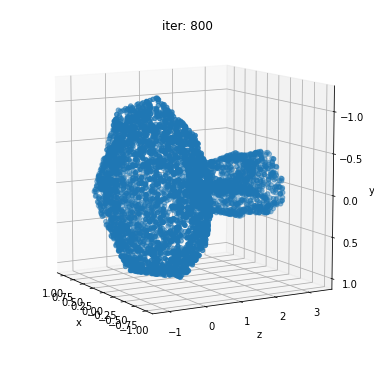

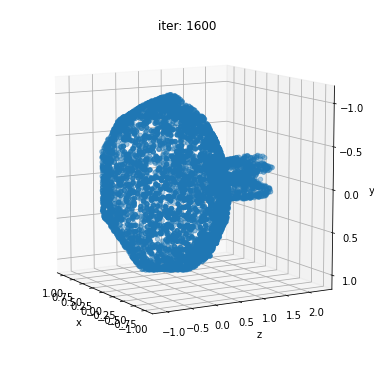


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


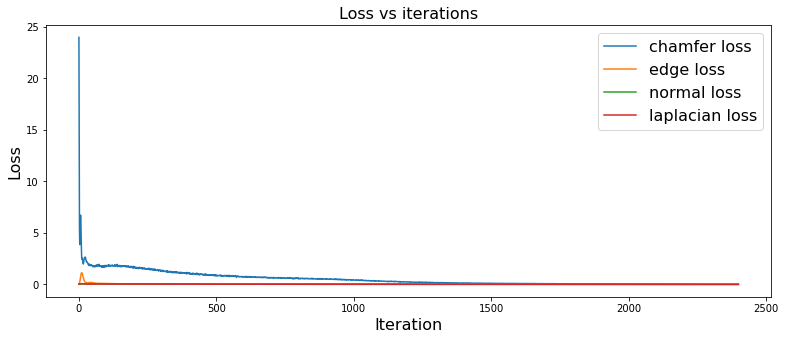


Deforming semi_sphere into sphere


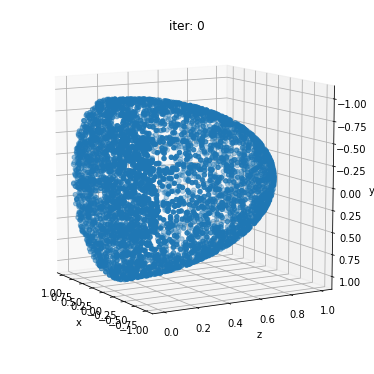

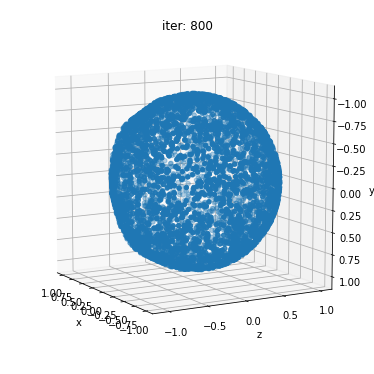

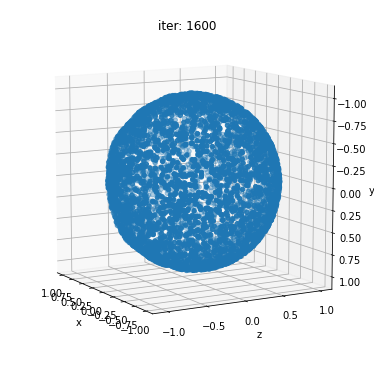


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


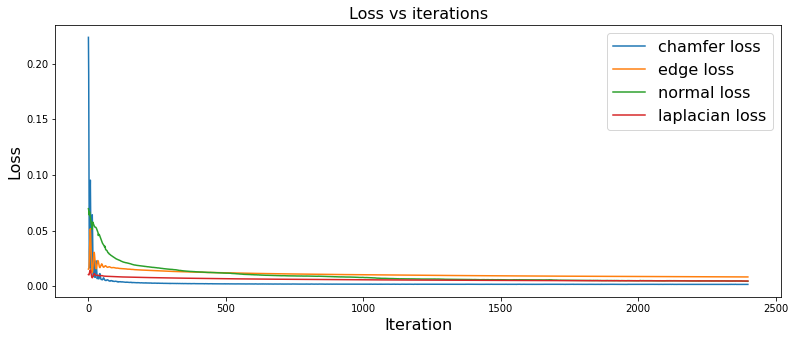

In [25]:
for source, target in pairs:
    print('\nDeforming {} into {}'.format(source[0], target[0]))
    optimized_mesh = deform_mesh(source[1], target[1], steps=2400, plot_period=800)
    save_mesh(optimized_mesh, 'opt-{}-{}.obj'.format(source[0], target[0]))


Deforming cone into sphere


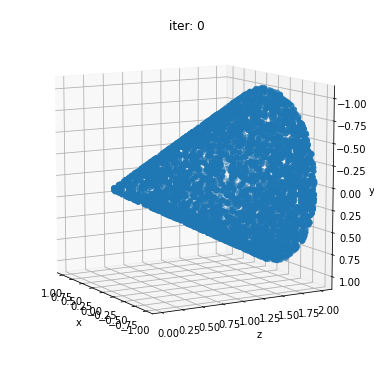

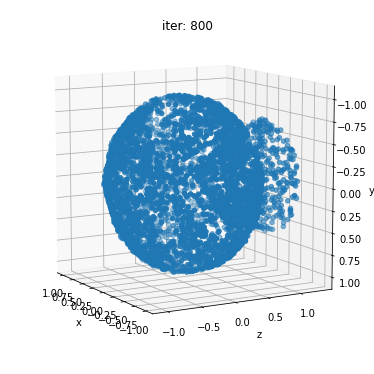

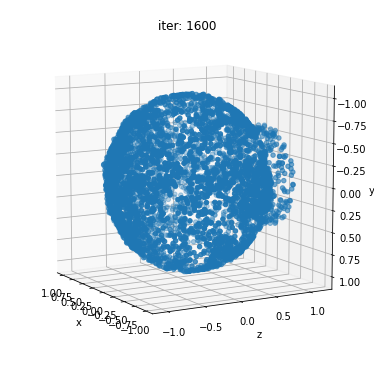


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


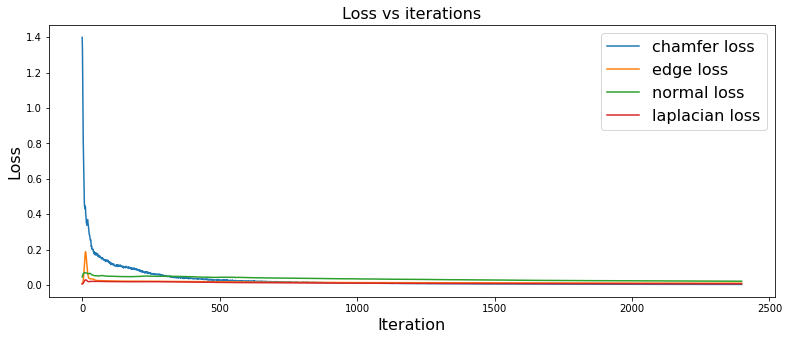


Deforming sphere into cone


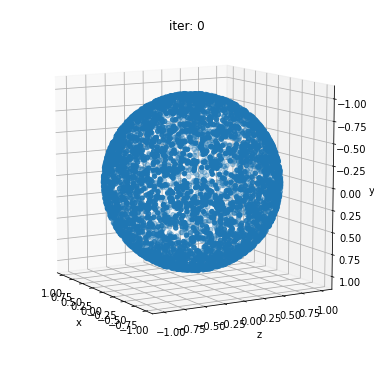

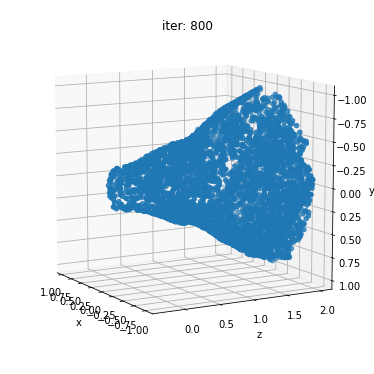

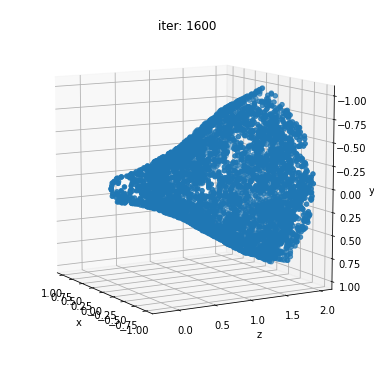


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


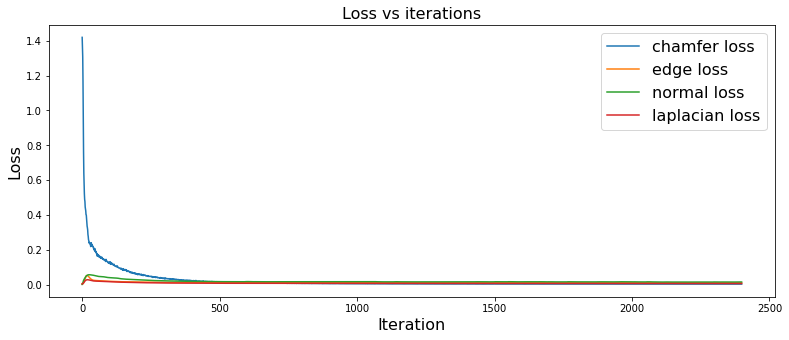

In [29]:
pairs = (
    (('cone', surface_of_revolution(line, 100, 50)), ('sphere', ico_sphere(4))), 
    (('sphere', ico_sphere(4)), ('cone', surface_of_revolution(line, 100, 50)))
)

#before smoothness
for source, target in pairs:
    print('\nDeforming {} into {}'.format(source[0], target[0]))
    steps = 2400
    optimized_mesh = deform_mesh(source[1], target[1], steps=steps, plot_period=800)
    save_mesh(optimized_mesh, 'opt-{}-{}-{}.obj'.format(source[0], target[0], steps))


Deforming open cone into sphere


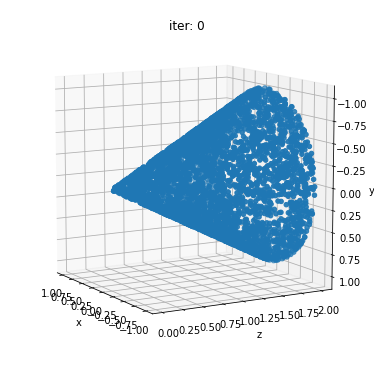

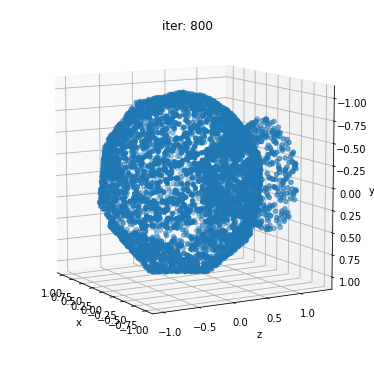

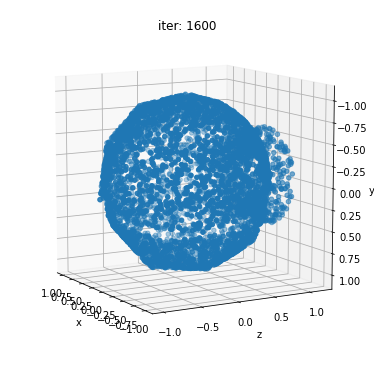


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


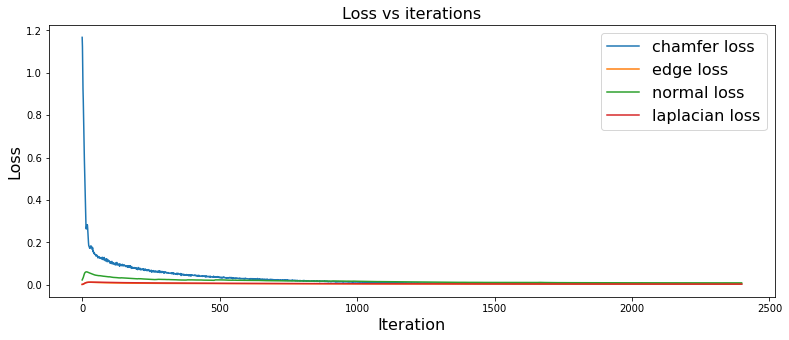

In [30]:
pairs = (
    (('cone', surface_of_revolution(line, 100, 50, closed=False)), ('sphere', ico_sphere(4))),
)

#before smoothness
for source, target in pairs:
    print('\nDeforming open {} into {}'.format(source[0], target[0]))
    steps = 2400
    optimized_mesh = deform_mesh(source[1], target[1], steps=steps, plot_period=800)
    save_mesh(optimized_mesh, 'opt-open-{}-{}-{}.obj'.format(source[0], target[0], steps))

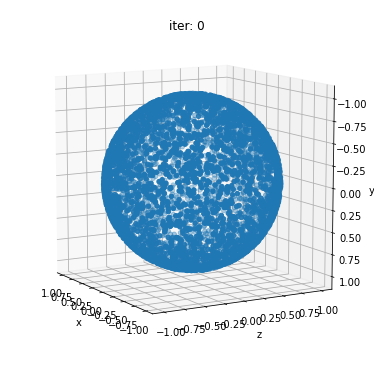

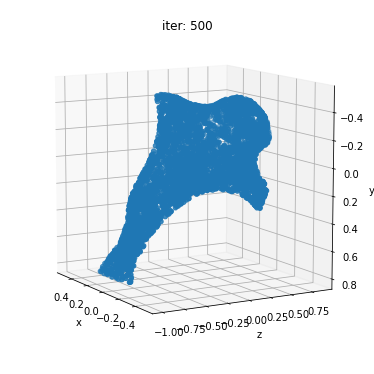

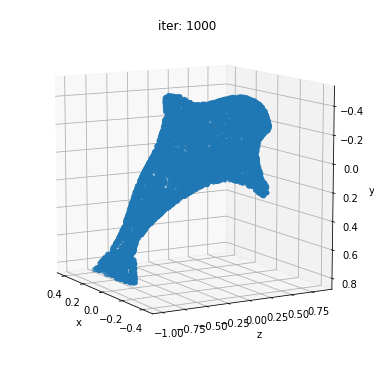

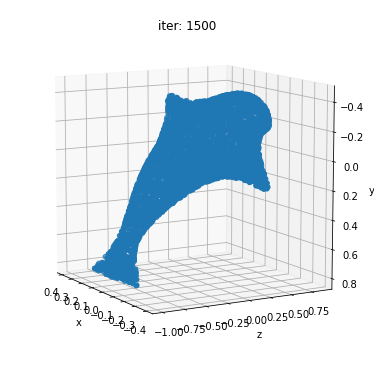


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


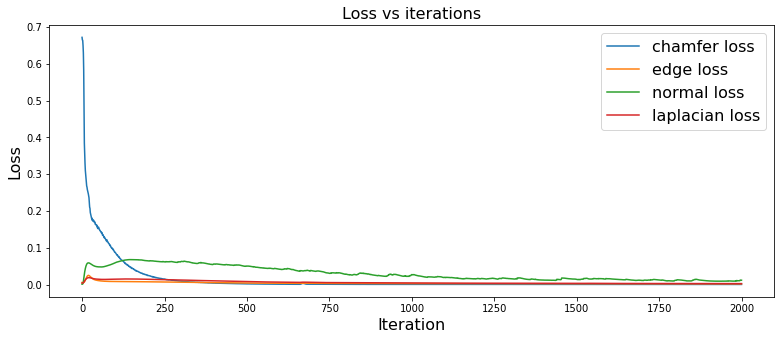

In [35]:
verts, faces, aux = load_obj('data/meshes/dolphin.obj')
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

dolphin_mesh = Meshes(verts=[verts], faces=[faces_idx])
sphere_mesh = ico_sphere(4)
steps = 2000
optimized_mesh = deform_mesh(sphere_mesh, dolphin_mesh, steps=steps, plot_period=500)

In [36]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = optimized_meshimized_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

In [34]:
save_mesh(optimized_mesh, 'opt-dolphin.obj'.format('sphere', 'dolphin', steps))

/Users/hallpaz/Workspace/impa/s3d/venv/lib/python3.7/site-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


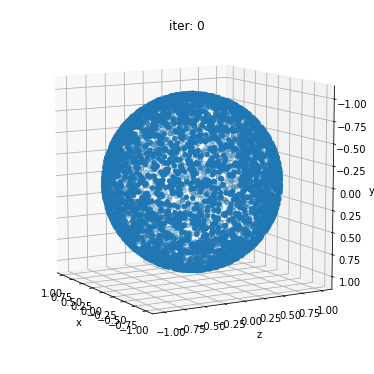

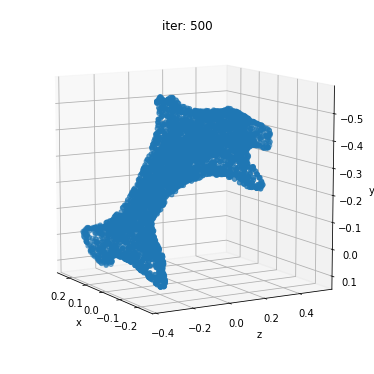

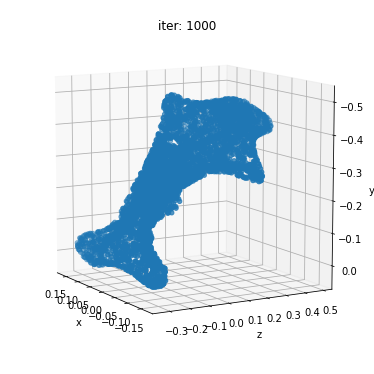

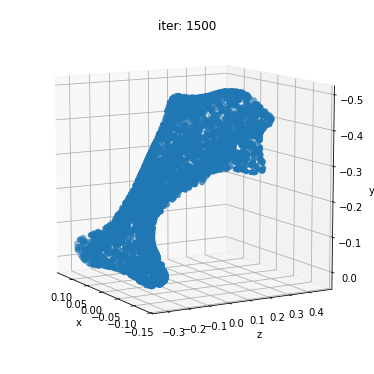

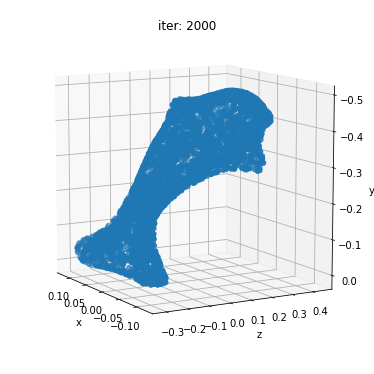


Weights:
 Chamfer: 1.0 | Edge: 1.0 | Normal: 0.01 | Laplacian: 0.1


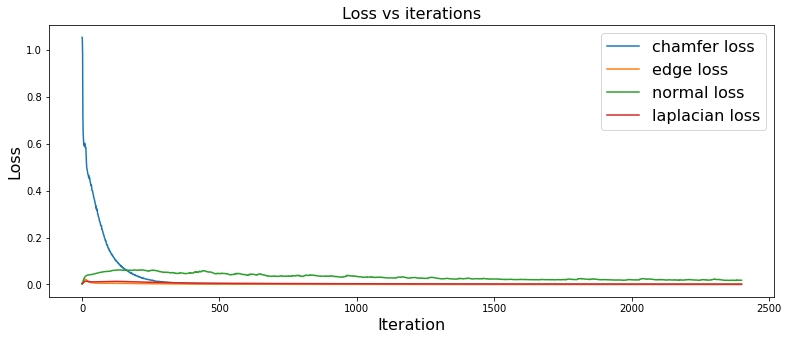

In [37]:
verts, faces, aux = load_obj('data/meshes/dolphin.obj')
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

dolphin_mesh = Meshes(verts=[verts], faces=[faces_idx])
sphere_mesh = ico_sphere(4)
steps = 2400
optimized_mesh = deform_mesh(sphere_mesh, dolphin_mesh, steps=steps, plot_period=500)

In [38]:
save_mesh(optimized_mesh, 'opt-dolphin2400.obj'.format('sphere', 'dolphin', steps))